In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import sys
sys.path.append('..')
from pvpro import PvProHandler
from solardatatools import DataHandler
from solardatatools.dataio import load_constellation_data

In [17]:
# df, js = load_constellation_data(5044, json_file=True) #5297 same as 5302 ??
# df, js = load_constellation_data(5317, json_file=True) # clipping detection failed
# df, js = load_constellation_data(5217, json_file=True)
# df, js = load_constellation_data(5297, json_file=True)
# df, js = load_constellation_data(5048, json_file=True)
df, js = load_constellation_data(5005, json_file=True)

In [18]:
volt_cols = [i for i in df.columns if 'dc_volt' in i]
pow_cols = [i for i in df.columns if 'dc_pow' in i]
curr_cols = [i for i in df.columns if 'dc_cur' in i]
irr_cols = [i for i in df.columns if 'poa' in i]
modT_cols = [i for i in df.columns if 'temperature_module' in i]

if len(pow_cols) == 0 & (len(volt_cols) != 0 & len(curr_cols) != 0):
    pow_cols = ['dc_power_inv_{}'.format(key.split('_')[-1]) for key in volt_cols]
    for ix, pc in enumerate(pow_cols):
        df[pc] = df[volt_cols[ix]] * df[curr_cols[ix]]

if len(modT_cols) == 0:
    print('Site has no module temperature measurements!')

In [44]:
sys_ix = 0
mps = js['Inverters']['Inverter 0']['modules_per_string']
ps = js['Inverters']['Inverter 0']['num_strings']
pvp = PvProHandler(df,
                   system_name='pvfleets',
                   delta_T=3,
                   cells_in_series=60,
                   resistance_shunt_ref=400,
                   alpha_isc=0.001,
                   voltage_key=volt_cols[sys_ix],
                   current_key=curr_cols[sys_ix],
                   temperature_module_key=modT_cols[0],
                   irradiance_poa_key=irr_cols[0],
                   modules_per_string=mps,
                   parallel_strings=ps,
                   )

In [56]:
pvp.run_preprocess(correct_dst=False, fix_shifts=False, max_val=180)

../pvpro/main.py:214: UserWarning: Maximum module temperature is larger than 85 C. Double check that input temperature is in Celsius, not Farenheight.
  'Maximum module temperature is larger than 85 C. Double check that input temperature is in Celsius, not Farenheight.')


Finding clipped times...


In [57]:
pvp.dh.report()

Length:                7.33 years
Capacity estimate:     157.13 kW
Data sampling:         15 minute
Data quality score:    94.5%
Data clearness score:  49.6%
Inverter clipping:     True
Time shifts corrected: None
Time zone correction:  None


In [58]:
sns.set_context('talk')

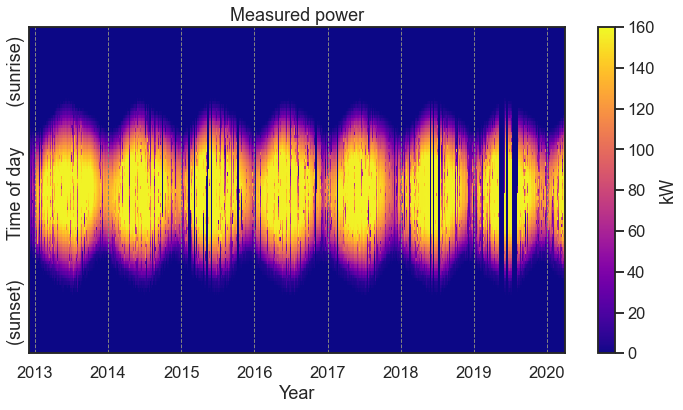

In [59]:
pvp.dh.plot_heatmap('filled');

In [60]:
print('-2', np.sum(pvp.df['operating_cls'] == -2))
print('-1', np.sum(pvp.df['operating_cls'] == -1))
print(' 0', np.sum(pvp.df['operating_cls'] == 0))
print(' 1', np.sum(pvp.df['operating_cls'] == 1))
print(' 2', np.sum(pvp.df['operating_cls'] == 2))

-2 668
-1 98462
 0 102527
 1 34584
 2 15626


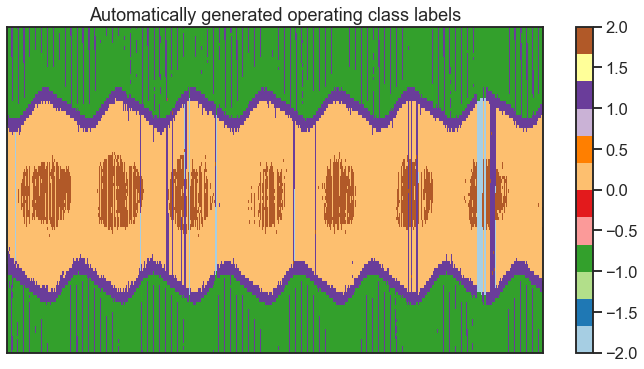

In [61]:
with sns.axes_style('white'):
    pvp.visualize_operating_cls();
    plt.title('Automatically generated operating class labels')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [37]:
# Set hyperparameters for running model.
hyperparams = {
    'use_voc_points': True,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'days_per_run': 30,
    'time_step_between_iterations_days': 30,
    'start_point_method': 'last',
    'save_figs_directory': 'figures',
    'plot_imp_max': 7,
    'plot_vmp_max': 35,
    'boolean_mask': None
}


--
Percent complete: 0.0%, Iteration: 0


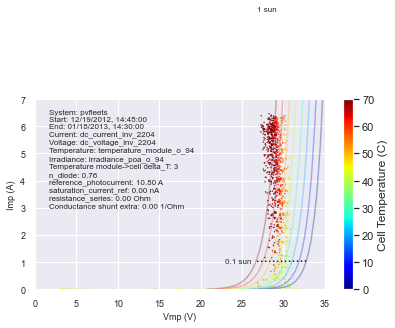

<Figure size 432x288 with 0 Axes>

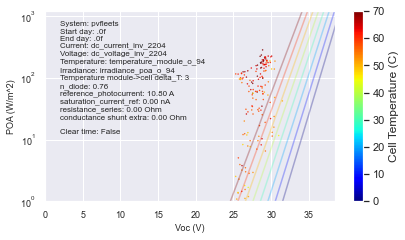

<Figure size 432x288 with 0 Axes>

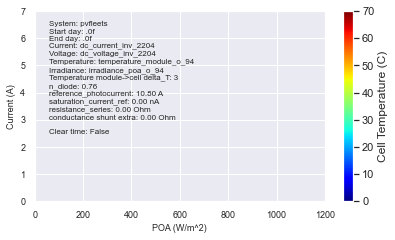

<Figure size 432x288 with 0 Axes>

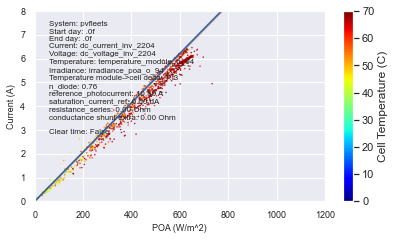


--
Percent complete: 1.1%, Iteration: 1


<Figure size 432x288 with 0 Axes>

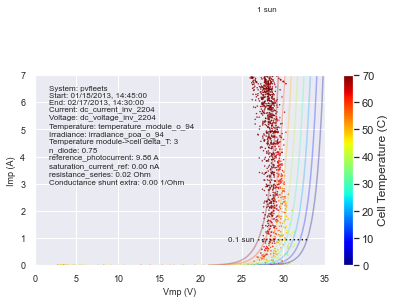

<Figure size 432x288 with 0 Axes>

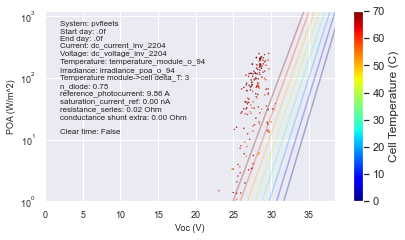

<Figure size 432x288 with 0 Axes>

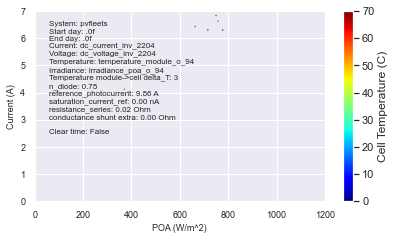

<Figure size 432x288 with 0 Axes>

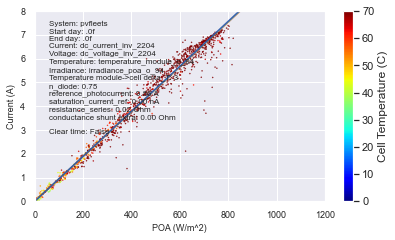

Elapsed time: 0.16 min


<Figure size 432x288 with 0 Axes>

In [79]:
ret = pvp.execute(iteration=[0,1],
                      save_figs=True,
                      verbose=False,
                      **hyperparams)